# Cargando las librerias utilizadas y haciendo los cambios de direcciones

In [ ]:
!pip install streamlit
!pip install tokenizers

In [2]:
import sys
import warnings
import os
from google.colab import drive
import pandas as pd
drive.mount('/content/drive')
warnings.filterwarnings("ignore")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
sys.path.append('/content/drive/MyDrive/mce/Cursos/dl/Modelo/Inferencia')
path = '/content/drive/MyDrive/mce/Cursos/dl/Modelo/Inferencia'
os.chdir(path)

In [4]:
import tqdm
import datetime
import matplotlib.pyplot as plt
import numpy as np
import streamlit as st
import tensorflow as tf
from skimage import io

In [5]:
from transformer import Transformer, default_hparams
from tokenizers import ByteLevelBPETokenizer

# Definición de las funciones a utilizar

In [6]:
def load_model(args):
  tokenizer = ByteLevelBPETokenizer(
        os.path.join(args['vocab_root'], 'mimic-vocab.json'),
        os.path.join(args['vocab_root'], 'mimic-merges.txt'),
    )
  transformer = Transformer(
        num_layers=hparams['num_layers'],
        d_model=hparams['d_model'],
        num_heads=hparams['num_heads'],
        dff=hparams['dff'],
        target_vocab_size=tokenizer.get_vocab_size(),
        dropout_rate=hparams['dropout_rate'],
        input_shape=(224, 224, 1))
  transformer.load_weights(args['classifier_weights'])
  return transformer, tokenizer

In [7]:
def top_k_logits(logits, k):
    if k == 0:
        # no truncation
        return logits

    def _top_k():
        values, _ = tf.nn.top_k(logits, k=k)
        min_values = values[:, -1, tf.newaxis]
        return tf.where(
            logits < min_values,
            tf.ones_like(logits, dtype=logits.dtype) * -1e10,
            logits,
        )
    return tf.cond(
       tf.equal(k, 0),
       lambda: logits,
       lambda: _top_k(),
    )


In [8]:
def top_p_logits(logits, p):
    """Nucleus sampling"""
    batch, _ = logits.shape.as_list()
    sorted_logits = tf.sort(logits, direction='DESCENDING', axis=-1)
    cumulative_probs = tf.cumsum(tf.nn.softmax(sorted_logits, axis=-1), axis=-1)
    indices = tf.stack([
        tf.range(0, batch),
        # number of indices to include
        tf.maximum(tf.reduce_sum(tf.cast(cumulative_probs <= p, tf.int32), axis=-1) - 1, 0),
    ], axis=-1)
    min_values = tf.gather_nd(sorted_logits, indices)
    return tf.where(
        logits < min_values,
        tf.ones_like(logits) * -1e10,
        logits,
    )

In [9]:
def evaluate(inp_img, tokenizer, transformer, temperature, top_k, top_p, options, seed, MAX_LENGTH=128):

    # The first token to the transformer should be the start token
    output = tf.convert_to_tensor([[tokenizer.token_to_id('<s>')]])

    my_bar = st.progress(0)
    for i in tqdm.tqdm(range(MAX_LENGTH)):
        my_bar.progress(i/MAX_LENGTH)

        # predictions.shape == (batch_size, seq_len, vocab_size)
        predictions = transformer([inp_img, output], training=False)
        # select the last word from the seq_len dimension
        predictions = predictions[:, -1, :] / temperature  # (batch_size, vocab_size)
        predictions = top_k_logits(predictions, k=top_k)
        predictions = top_p_logits(predictions, p=top_p)

        if options == 'Greedy':
            predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)[:, tf.newaxis]
        elif options == 'Sampling':
            predicted_id = tf.random.categorical(predictions, num_samples=1, dtype=tf.int32, seed=seed)
        else:
            st.write('SHOULD NOT HAPPEN')

        # return the result if the predicted_id is equal to the end token
        if predicted_id == 2:  # stop token #tokenizer_en.vocab_size + 1:
            my_bar.empty()
            break

        # concatentate the predicted_id to the output which is given to the decoder
        # as its input.
        output = tf.concat([output, predicted_id], axis=-1)

    my_bar.empty()

    # transformer([inp_img, output[:, :-1]], training=False)
    return tf.squeeze(output, axis=0)[1:], transformer.decoder.last_attn_scores

In [ ]:
 st.sidebar.title('Configuration')
options = st.sidebar.selectbox('Generation Method', ('Greedy', 'Sampling'))
seed = st.sidebar.number_input('Sampling Seed:', value=42)
temperature = st.sidebar.number_input('Temperature', value=1.)
top_k = st.sidebar.slider('top_k', min_value=0, max_value=tokenizer.get_vocab_size(), value=6, step=1)
top_p = st.sidebar.slider('top_p', min_value=0., max_value=1., value=1., step=0.01)
attention_head = st.sidebar.slider('attention_head', min_value=-1, max_value=7, value=-1, step=1)

In [13]:
def report(url):

  img_array = io.imread(url, as_gray=True)[None, ..., None]
  # Convert image to float values in (0, 1)
  img_array = tf.image.convert_image_dtype(img_array, tf.float32)

  # Resize image with padding to [1, 224, 224, 1]
  img_array = tf.image.resize_with_pad(img_array, 224, 224, method=tf.image.ResizeMethod.BILINEAR)

  # Display input image
  st.image(np.squeeze(img_array.numpy()), caption='Uploaded Image')

  # Log datetime
  print('[{}] Running Analysis...'
        .format(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")))

  # Generate radiology report
  with st.spinner('Generating report... Do not refresh or close window.'):
      result, attention_weights = evaluate(img_array, tokenizer, transformer,
                                            temperature, top_k, top_p,
                                            options, seed)
      predicted_sentence = tokenizer.decode(result)
  return predicted_sentence

In [10]:
args = {'csv_root':path+'/mimic',
        'vocab_root':path+'/mimic',
        'mimic_root':path+'/',
        'model_name':'RATCHETESP',
        'model_params':path+'/hparams.json',
        'classifier_weights':path+'/checkpoints/RATCHETESP.tf',
        'n_epochs':20,
        'init_lr':None,
        'batch_size':16,
        'seed':42}
hparams = default_hparams()

In [16]:
def probar(conjunto):
  if conjunto=='train':
    df = pd.read_csv(path+'/mimic/MIMIC_AP_PA_train.csv')
    id = [14843]
    conj='train'
  else:
    df = pd.read_csv(path+'/mimic/MIMIC_AP_PA_test.csv')
    id = [140,169]
    conj='test'
  reportes = []
  predicciones = []
  imagenes = []
  for i in id:
    img_path = '/content/drive/MyDrive/mce/Cursos/dl/Modelo/Entrenamiento'+'/'+df.loc[i]['DicomPath']
    reportes.append(df.loc[i]['Reports'])
    predicciones.append(report(img_path))
    imagenes.append(img_path)
  for i in range(len(id)):
    img_array = io.imread(imagenes[i], as_gray=True)[None, ..., None]
    img_array = tf.image.convert_image_dtype(img_array, tf.float32)
    img_array = tf.image.resize_with_pad(img_array, 224, 224, method=tf.image.ResizeMethod.BILINEAR)
    print(f"Texto esperado:",reportes[i])
    print(f"Texto obtenido:",predicciones[i])
    plt.imshow(np.squeeze(img_array),cmap='Greys')
    plt.savefig(path+'id='+str(id[i])+'.png')
    plt.show();

# Cargando modelo

In [11]:
transformer, tokenizer= load_model(args)

2023-12-11 02:19:48.984940: I No Pretrained DenseNet-121 weights specified


# Realizando pruebas del modelo

[2023-12-11 02:21:27] Running Analysis...


 55%|█████▌    | 71/128 [02:22<01:54,  2.01s/it]


[2023-12-11 02:23:51] Running Analysis...


  5%|▍         | 6/128 [00:07<02:36,  1.28s/it]


Texto esperado: Cardiomegalia y congestion venosa.
Texto obtenido:  comparacion con el estudio de ___, hay pocos cambios y no hay evidencia de enfermedad cardiopulmonar aguda.La silueta cardiaca esta en los limites superiores de tamano normal.La opacificacion en la base derecha es consistente con la perdida de volumen en el lobulo inferior izquierdo.La opacificacion en la base derecha es consistente con el derrame pleural y la atelectasia compresiva en el lobulo inferior izquierdo.


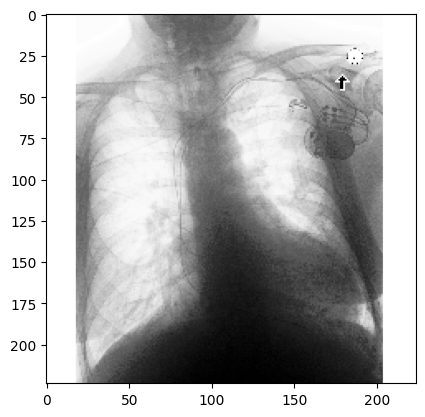

Texto esperado: Apariencia estable del pecho.
Texto obtenido: No hay proceso cardiopulmonar agudo.


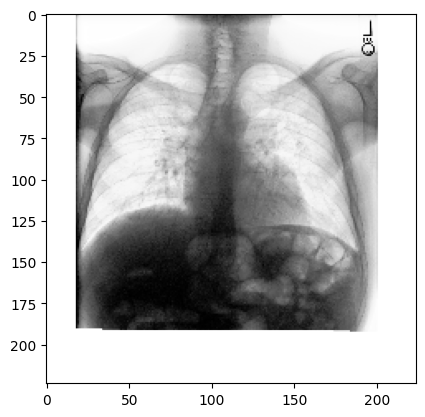

In [17]:
probar('test')

[2023-12-11 02:24:05] Running Analysis...


 55%|█████▌    | 71/128 [01:47<01:26,  1.52s/it]


Texto esperado: Cardiomegalia y tortuosidad significativa de la aorta toracica descendente.No hay proceso cardiopulmonar agudo.
Texto obtenido:  comparacion con el estudio de ___, hay pocos cambios y no hay evidencia de enfermedad cardiopulmonar aguda.La silueta cardiaca esta en los limites superiores de tamano normal. hay una elevacion leve de la presion venosa pulmonar.La opacificacion en la base derecha es consistente con la atelectasia.La opacificacion en la base derecha es consistente con la perdida de volumen en el lobulo inferior izquierdo.


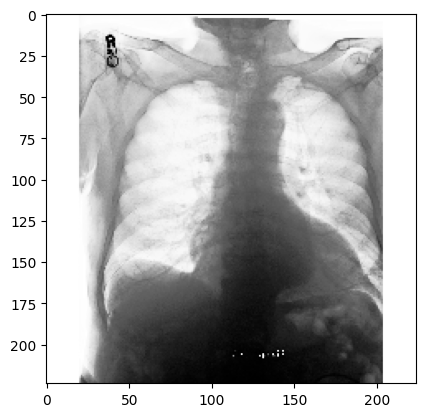

In [18]:
probar('train')